# **Assignment \#3**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2022s2



In [2]:
# TODO: RA & Name 
print('182503: ' + 'Lucas Luiz de Castro Gomes')
print('221518: ' + 'Marcos Confuorto Morelis')

182503: Lucas Luiz de Castro Gomes
221518: Marcos Confuorto Morelis


## Objective 

Explore **neural networks** and develop the best possible model for the problem, avoiding overfitting. In particular, build an object recognition system to classify images using the [BloodMNIST dataset](https://doi.org/10.1016/j.dib.2020.105474) accurately. 

In this activity, **you are not allowed to use neural networks frameworks** (e.g., Pytorch, Tensorflow, Keras), except basic functions such as Dataloaders which are already specified in the code cells. You should implement the required methods using [NumPy](https://numpy.org/doc/1.23/user/index.html#user). Also, you can use ``scikit-learn`` (or similar libraries) to compute evaluation metrics, and all the plotting libraries are allowed too. 

We created a sanity check for all the methods you have to implement, so you can check whether the overall behavior of your algorithm is correct. However, it does not guarantee that your implementation is correct, unfortunately debugging neural networks models is a hard task.

## Dataset

BloodMNIST is one of the image datasets of [MedMNIST](https://medmnist.com/). It is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. It is split into a training set of 11,959 examples, a validation set of 1,712 examples, and a test set of 3,421 examples. Each example is a 3x28x28 RGB image, associated with a label from 8 classes.

Each example is assigned to one of the following labels:

|Class ID| Cell Type | #Images | % |
|--------|-----------|---------|---|
|   0    | basophils | 1218 | 7.13 |
|   1    | eosinophils | 3117 | 18.24 |
|   2    | erythroblasts | 1551 | 9.07 |
|   3    | immature granulocytes | 2895 | 16.94 |
|   4    | lymphocytes | 1214 | 7.10 |
|   5    | monocytes | 1420 | 8.31 |
|   6    | neutrophils | 3329 | 19.48 |
|   7    | platelets (thrombocytes) | 2348 |13.74 |


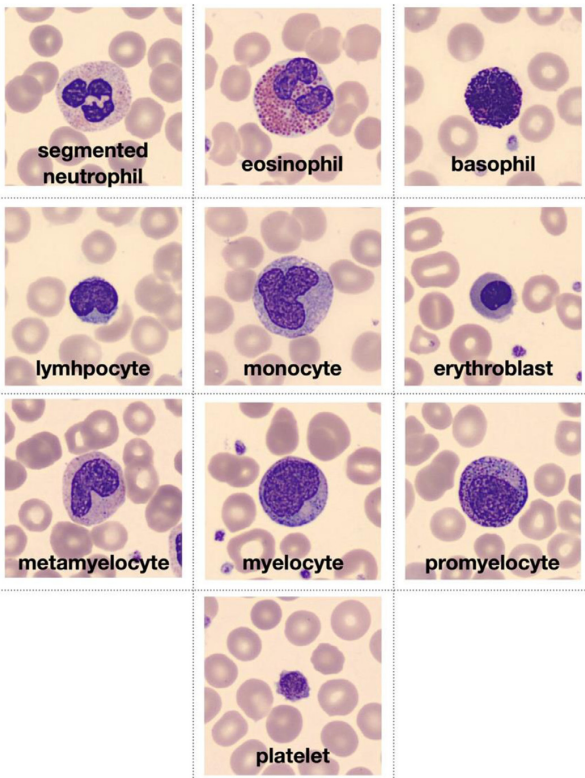

**Dataset Information:**

- You should respect the following training/validation/test split. Avoid overfitting.
- The data is available at Google Classroom or at https://drive.google.com/file/d/1DPGlDIRp_kGqhHyUAlkL7OH8RVbkRRbi/view?usp=sharing
- You should evaluate the models using **balanced accuracy** or **AUC**.

## Deadline
Friday, October 21 11:59pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- October 22 11:59pm : grade * 0.75
- October 23 11:59pm : grade * 0.5
- October 24 11:59pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-people group).**

In [84]:
from typing import List
from abc import ABC,abstractmethod
from torch.utils.data import Dataset, DataLoader
import torch 

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from math import exp
from math import log10
import pandas as pd

In [85]:
# prepare data to use with Pytorch Dataloader

class BloodMNIST(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y.squeeze() if y is not None else None
        self._transform = transform

    def __len__(self):
        return self._x.shape[0]

    def __getitem__(self, idx):                  
        image = self._x[idx]
        if self._transform is not None:        
            image = self._transform(image)
        
        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * 8
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [86]:
# an example of normalization function, but you can implement others
def normalize(X):
    return (X - X.mean())/(X.std() + 1e-8)

#### Loading data

In [87]:
# set the dataset path correctly 
dataset_path = 'bloodmnist.npz'
bloodmnist = np.load(dataset_path)

x_train, y_train = bloodmnist['train_images'], bloodmnist['train_labels']
x_val, y_val = bloodmnist['val_images'], bloodmnist['val_labels']

# you do not have access to the labels of the test set
x_test = bloodmnist['test_images']

In [88]:
train_set = BloodMNIST(x_train, y_train, transform=normalize)
val_set = BloodMNIST(x_val, y_val, transform=normalize)
test_set = BloodMNIST(x_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

## Implementation tasks

#### Activation & Loss Functions

Activation functions are essential components of a neural network. So, explore different activation functions in your models and analyze the differences in the results. Also, implement the cross-entropy and use it as your loss function since you are working on a multi-class classification problem.

Implement, in the indicated place, the following functions:

* Softmax (its gradient is already implemented);
* Cross-Entropy (its gradient is already implemented);
* An activation function of your preference, as well as its gradient. It must be a subclass of ``BaseFunction``. (For reference, read this [blog post](https://dwaithe.github.io/blog_20170508.html).)

In [89]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass
        
    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):    
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)

########################################################
# TODO: implement here another activation function

class PReLU(BaseFunction):    
      def __call__(self, X, alpha = 0):
        self.alpha = alpha
        return np.where(X < 0, self.alpha*X, X)

      def grad(self, X, alpha = 0):
        return np.where(X < 0, self.alpha, 1)

########################################################



class Softmax(BaseFunction):
  def __call__(self, X):
    s = np.exp(X)
    return s/np.sum(s, axis = 1).reshape([len(np.sum(s, axis = 1)),1])

  def grad(self, X):
        return 1 # discard this gradient



        
        ##################################
        # TODO: implement here the Cross-Entropy
        ##################################
class CrossEntropy(BaseFunction):    
    def __call__(self, Y, Y_pred):
      ce = -np.log(Y_pred+ 1e-8)*Y
      return np.sum(ce)/Y.shape[0]
        

    def grad(self, Y, Y_pred):
        return Y_pred - Y # gradient with respect to Softmax's input

**Sanity Check**

In [90]:
######## checking Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])
result_softmax = s(x)
assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"Expected result for softmax is {expected_softmax}, but it returns {result_softmax}"

In [91]:
######## checking CrossEntropy ########

Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])


expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred) 
assert abs(ce_result - expected_ce) < 1e-8, f"Expected result for cross entropy is {expected_ce}, but it returns {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])
grad = cross_entropy.grad(Y, Y_pred)
assert (abs(grad - expected_grad) < 1e-8).all(), f"Expected result for cross entropy gradient is {expected_grad}, but it returns {grad}"

#### Model

In a neural network, the predictions are made using an algorithm called Feedforward, also known as the forward step. Thus, you have to implement this method to make predictions using your models. 

In addition, it is critical to initialize the network weights properly to ensure a better-performing model. Otherwise, it can give rise to a Vanishing Gradient or Exploding Gradient problem. So, try different weights initialization techniques and see what happens. We already implemented the random and [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) Normal initialization for you :D

Implement, in the indicated place, the following methods:

* Feedforward, also known as the forward step;
* A weight initialization method of your choice. (For reference, read this [blog post](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).)

PS. Note that the weight matrices $W$ in the network are constructed so that $w^{l}_{i,j}$ is the weight that connects the i-th neuron in the l-th layer to the j-th neuron in the following layer, as illustrated below.



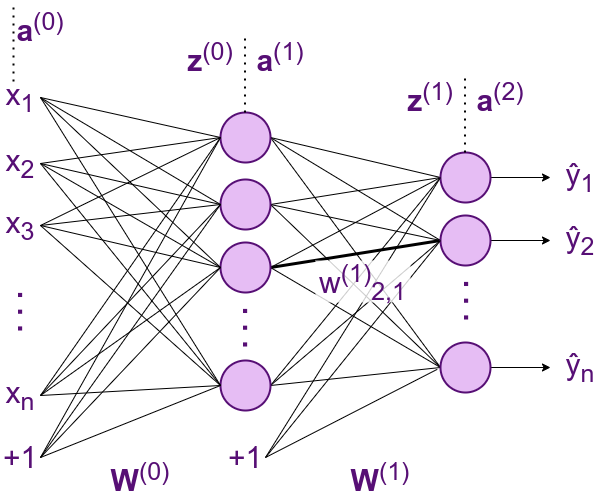


**Feed Forward**:

$a^{(l)} = f_{(l-1)}(z^{(l-1)})$

In [92]:
class Model:
    def __init__(self, layers_dims: List[int], 
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        activation_funcs: (list) a list with the activation functions 
        initialization_method: (str) indicates how to initialize the parameters

        Example:
        
        # a model architecture with layers 2 x 1 x 2 and 2 ReLU as activation functions
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "It is expected a list of int to the param ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "It is expected a list of BaseFunction to the param ``activation_funcs´´"
        
        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)


    def __len__(self):
        return len(self.weights)


    def initialize_model(self, method="random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        method: (str) indicates how to initialize the parameters

        Return: a list of matrices (np.array) of weights and a list of 
        matrices (np.array) of biases.
        """
        
        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        for l in range(0, n_layers-1):
            # the weight w_i,j  connects the i-th neuron in the current layer to
            # the j-th neuron in the next layer          
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1])
            b = np.random.randn(1, self.layers_dims[l + 1])
            
            # He et al. Normal initialization
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l])
                b = b * np.sqrt(2/self.layers_dims[l])

            ###################################################
            # TODO: implement another initialization method
            #
            # if method.lower() == 'Your Method':
            #   ...
            ###################################################

            if method.lower() == 'xavier':
                W = W * np.sqrt(6/(self.layers_dims[l] + np.where(l<n_layers-1,self.layers_dims[l+1],0)))
                b = b * np.sqrt(6/(self.layers_dims[l] + np.where(l<n_layers-1,self.layers_dims[l+1],0)))

            weights.append(W)
            bias.append(b)

        return weights, bias


    def forward(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Predictions for the input data (np.array)
        """      
        activation = X
        self.activations = [X]
        self.Z_list = []
        #############################################################################
        # TODO: implement here the forward step.
        #
        # A few more instructions:
        # Note that the weights, bias and activation functions are class variables,
        # then you can access them via ``self``.
        #
        # You should store the input Z of each activation function in ``Z_list``,
        # and the output of the activation functions in ``activations``. These
        # information will be important when you implement the backward pass.
        #############################################################################
        n_layers = len(self.layers_dims)
        for c in range(0, n_layers-1):

            z = np.dot(self.activations[c] , self.weights[c]) + self.bias[c]
            self.Z_list.append(np.array(z))

            z = self.activation_funcs[c](z)
            self.activations.append(z)
            
        return(self.activations[-1])


            
        pass

**Sanity check**

In [93]:
######## checking Forward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()])

X = np.array([[0 ,1],
              [-1,0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])
W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),                
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,                        
                        np.array([[2],
                                  [0]]),                                            
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: expected Z list is {expected_z}, but it returns {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a-expected_a) < 1e-8).all(), \
    f"Forward pass {l}: expected activations are {expected_a}, but it returns {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: expected result is {expected_prediction}, but it returns {prediction}"

#### Optimizers

Once you have designed your neural network's topology/architecture, it is time to train it. To do so, you need to select an optimizer (e.g., SGD, Momentum, Adagrad, Adam, RMSProp) that will update the network's weights. 

Implement in the indicated place:

* Stochastic Gradient Descent (SGD);
* Another optimizer of your preference. It must be a subclass of ``BaseOptimizer``. (For reference, read http://ruder.io/optimizing-gradient-descent.)

In [100]:
class BaseOptimizer(ABC):    
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """
        ###############################################################
        # TODO: implement Stochastic Gradient Descent (SGD) algorithm
        ###############################################################
        
        weights = []
        bias = []
        for j in range(0,len(self.model.layers_dims)-1):
            weights_grad, bias_grad = grads[j]
            bias.append(self.model.bias[j]          - self.lr * bias_grad)
            weights.append(self.model.weights[j]    - self.lr * weights_grad)
        self.model.weights = weights
        self.model.bias = bias

        return()

###################################
# TODO: implement another optimizer
###################################        
class MomentumSGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3, gamma=0.9):
        self.model      = model
        self.lr         = lr
        self.gamma      = gamma
        self.vt_weight  = [0 for _ in range(len(model.layers_dims)-1)]
        self.vt_bias    = [0 for _ in range(len(model.layers_dims)-1)]
        

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """
        n_layers = len(self.model.layers_dims)

        weights = []
        bias    = []
        for j in range(0,n_layers-1):
            weights_grad, bias_grad = grads[j]

            self.vt_bias[j]     = (self.gamma * self.vt_bias[j]    + self.lr * bias_grad)
            self.vt_weight[j]   = (self.gamma * self.vt_weight[j]  + self.lr * weights_grad)

            bias.append(self.model.bias[j]          - self.vt_bias[j])
            weights.append(self.model.weights[j]    - self.vt_weight[j])

        self.model.weights  = weights
        self.model.bias     = bias
            

        pass   

**Sanity check**

The sanity check of SGD is placed after ``Trainer`` because it uses the backpropagation algorithm to compute the gradients.

#### Trainer

A weight $w_{i,j}$ of a neural network is updated based on the gradient of the loss function for $w_{i,j}$. Then, we need to compute the gradient of the loss function with respect to all the weights and biases in each layer in the network. This process is called backpropagation, a.k.a backward step. 

Implement:
* Backpropagation algorithm.

> *Hint: use the following recursive equations to compute the backpropagation.*
>
> $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial C}{\partial z^{(L-1)}}$
>
> $\frac{\partial C}{\partial z^{(l)}} = [\frac{\partial C}{\partial z^{(l+1)}} \cdot W_{(l+1)}^T] \odot \frac{\partial f_{(l)}}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial W^{(l)}} = \frac{1}{m} \cdot a^{(l)^T} \cdot \frac{\partial C}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial b^{(l)}} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial C}{\partial z_i^{(l)}}$
>
> Where $C$ is your cost/loss function, $m$ is the batch size,  $a^{(L)}$ is the last activation function output, $z_i^{(l)}$ is the i-th row of the matrix $z^{(l)}$, and $\odot$ is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))/element-wise product. 

In [95]:
class Trainer:
    def __init__(self, model, optimizer, loss_func):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.batch_size = 0

    def backward(self, Y):
        """
        Arguments:
        Y: (np.array) ground truth/label vector.

        Return: 
        A list of tuples of matrices (weights' gradient, biases' gradient) both in np.array format.
        The order of this list should be the same as the model's weights. 
        For example: [(dW0, db0), (dW1, db1), ... ].
        """
        ############################################################
        # TODO: implement here the backward step.
        ############################################################

        grads = []

        n_layers = len(self.model.layers_dims)
        Y_pred = self.model.activations[-1]
        Z = self.model.Z_list[-1]
        dZ = self.loss_func.grad(Y, Y_pred) * self.model.activation_funcs[-1].grad(Z)
        
        for i in reversed(range(n_layers - 1)):
            dw = np.dot(self.model.activations[i].T, dZ)/self.batch_size
            db = np.sum(dZ/self.batch_size, axis=0, keepdims=True)
            grads.append((dw, db))

            if i > 0:
                W = self.model.weights[i]
                Z = self.model.Z_list[i-1]
                dZ = np.dot(dZ, W.T) * self.model.activation_funcs[i-1].grad(Z)
                
        grads.reverse()
        return (grads)
        
    
    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        """
        Arguments:
        n_epochs: (int) number of epochs
        train_loader: (DataLoader) train DataLoader
        val_loader: (DataLoader) validation DataLoader

        Return: 
        A dictionary with the log of train and validation loss along the epochs
        """
        log_dict = {'epoch': [], 
                   'train_loss': [], 
                   'val_loss': []}

        self.batch_size = train_loader.batch_size
        for epoch in tqdm.tqdm_notebook(range(n_epochs)):
            train_loss_history = []
            
            for i, batch in enumerate(train_loader):                
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()                         
                Y_pred = self.model.forward(X)
                train_loss = self.loss_func(Y, Y_pred)
                train_loss_history.append(train_loss)

                grads = self.backward(Y)
                self.optimizer.step(grads)

            val_loss_history = []
            for i, batch in enumerate(val_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                val_loss = self.loss_func(Y, Y_pred)
                val_loss_history.append(val_loss)

            # appending losses to history
            train_loss = np.array(train_loss_history).mean()
            val_loss = np.array(val_loss_history).mean()
            
            log_dict['epoch'].append(epoch)
            log_dict['train_loss'].append(train_loss)
            log_dict['val_loss'].append(val_loss)
        
        return log_dict

**Sanity check**

In [96]:
######## checking Backward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1], 
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)

# We let this value just in case you need to check your results
#
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])


expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"Expected result for dW1 is {expected_dW1}, but it returns {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"Expected result for db1 is {expected_db1}, but it returns {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"Expected result for dW0 is {expected_dW0}, but it returns {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"Expected result for db0 is {expected_db0}, but it returns {db0}"

In [97]:
######## checking SGD Optimizer ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1], 
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)
opt = SGDOptimizer(m, lr=1)
opt.step(grads)

expected_W0 = np.array([[2.  ],
                        [1.25]])
expected_b0 = np.array([[1.25]])

expected_W1 = np.array([[1.5, 3.5]])
expected_b1 = np.array([[ 0.80960146, -0.80960146]])

W0, b0 = m.weights[0], m.bias[0]
assert (abs(expected_W0 - W0) < 1e-8).all(), f"Expected result for W0 after SGD update step is {expected_W0}, but it returns {W0}"
assert (abs(expected_b0 - b0) < 1e-8).all(), f"Expected result for b0 after SGD update step is {expected_b0}, but it returns {b0}"

W1, b1 = m.weights[1], m.bias[1]
assert (abs(expected_W1 - W1) < 1e-8).all(), f"Expected result for W1 after SGD update step is {expected_W1}, but it returns {W1}"
assert (abs(expected_b1 - b1) < 1e-8).all(), f"Expected result for b1 after SGD update step is {expected_b1}, but it returns {b1}"

#### Usage example

Usage example of the framework we just created.

In [98]:
# Auxiliar function to plot loss along the epochs
def plot_history(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots()
    ax.plot(history['train_loss'], color='#407cdb', label='Train')
    ax.plot(history['val_loss'],color='#db5740', label='Validation')
    
    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss along the training')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

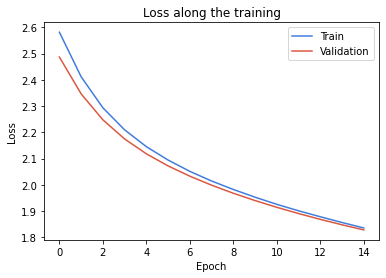

In [18]:
model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

## Exploratory activities

For all exercises, plot the loss along the epochs and print your model's performance in the validation set.


1. (1 point) Design a Neural Network, using one or two hidden layers, ReLU and softmax as activation functions, random weight initialization, and SGD to train it. You should choose an appropriate learning rate and a number of epochs.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


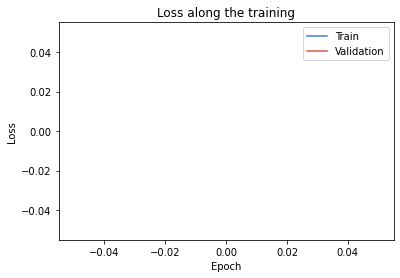

nan
nan


In [81]:
model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()])
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)
print(history['train_loss'][len(history['train_loss'])-1])
print(history['val_loss'][len(history['val_loss'])-1])

> What are the conclusions? (1-2 paragraphs)


Houve um problema de overflow no treinamento. Isso se deve ao fato de que utilizamos o método aleatório de inicialização dos pesos e viéses, que não é muito eficiente pois pode causar problemas como esse, fazendo com que o gradiente não converja para a solução correta

2. (2 points) Experiment other two weight & bias initialization techniques (He et al. Normalization, and the other one you implemented).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/250 [00:00<?, ?it/s]

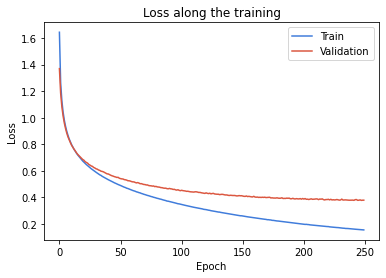

0.1539218573472118
0.3780979294384026


In [88]:
model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(250, train_loader, val_loader)
plot_history(history)
print(history['train_loss'][len(history['train_loss'])-1])
print(history['val_loss'][len(history['val_loss'])-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/250 [00:00<?, ?it/s]

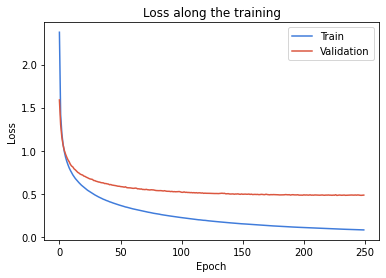

Custo treino 0.0801251590815912
Custo validação 0.4841988576826395


In [19]:
model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(250, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

> What are the conclusions? How do the techniques influence the performance of the models? (1-2 paragraphs) 

Ambas técnicas foram aplicadas utilizando um learning rate de 1e-3 e 250 épocas. Pode-se perceber que utilizando Xavier o custo final do conjunto de treino foi menor em comparação a Normalization, contudo em relação ao conjunto de validação na última época a primeira técnica obteve um resultado mais satisfatório.

Sendo assim optaremos por utilizar Normalization como método de inicialização dos pesos e viéses da nossa rede, tendo em vista que um custo muito baixo no conjunto de treino não é necessariamente algo bom, pois pode indicar que o modelo está overfitado no conjunto de treino. Em contrapartida o custo menor no conjunto de validação é muito bom, uma vez que o conjunto de validação não foi utilizado para treinar o modelo.

3. (1 point) Choose the weight & bias initialization technique that resulted in the best performance, and try the other activation function you implemented.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/250 [00:00<?, ?it/s]

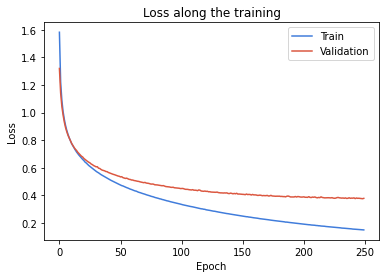

Custo treino 0.14900360962766188
Custo validação 0.3778872448102749


In [27]:
prelu = PReLU()
prelu.alpha = 0.5
model = Model([2352, 500, 100, 8], [prelu, prelu, Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(250, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

> What are the conclusions? Does it make any difference in the results? (1-2 paragraphs) 

Pode-se perceber que a diferença entre as duas funções de ativação em questão é muito pequena, tanto o custo do treino quanto da validação foram muito próximos nos 2 modelos. Sendo assim não é possível inferir que um modelo é melhor que o outro, pois esta pequena diferença pode decorrer da aleatoriedade do método de inicialização dos pesos, além disso é bem pequena também.

Provavelmente isso se deve ao fato de que as funções de ativação são similares sendo a ReLU um caso especial da PReLU em que o parâmetro alpha é igual a 0. 

4. (3 points) Explore different network architectures, varying the number of layers and the number of neurons in each layer. It is an empirical experiment.

In [29]:
#Para comparar vamos descobrir o custo do ultimo modelo na 50ª época
print(history['val_loss'][49])

0.5379476405313784


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40 [00:00<?, ?it/s]

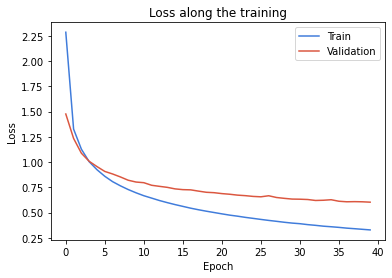

0.32814246398199337
0.6028826459305184
Custo treino 0.32814246398199337
Custo validação 0.6028826459305184


In [23]:
#Testando modelo com 5 camadas, sendo 3 camadas escondidas
model = Model([2352, 500, 400, 100, 8], [ReLU(), ReLU(), ReLU(),Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(40, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40 [00:00<?, ?it/s]

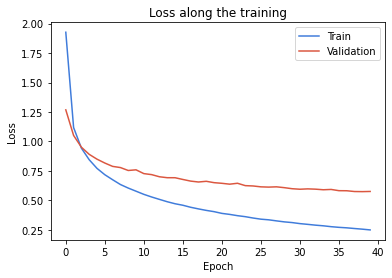

0.25033923220012766
0.5763976990250943
Custo treino 0.25033923220012766
Custo validação 0.5763976990250943


In [24]:
#Testando modelo com 5 camadas, sendo 3 camadas escondidas com camadas maiores
model = Model([2352, 1000, 1000, 100, 8], [ReLU(), ReLU(), ReLU(),Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(40, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40 [00:00<?, ?it/s]

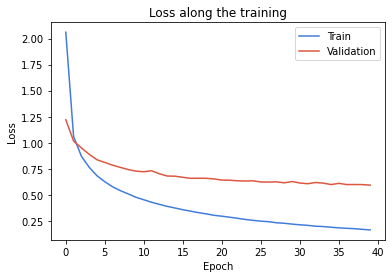

0.16271560998656104
0.5927908285243504
Custo treino 0.16271560998656104
Custo validação 0.5927908285243504


In [25]:
#Testando modelo com 6 camadas, sendo 4 camadas escondidas com camadas maiores
model = Model([2352, 1000, 1000, 500, 100, 8], [ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(40, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40 [00:00<?, ?it/s]

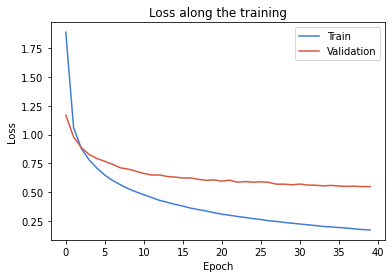

0.16957622342843648
0.5471364538017057
Custo treino 0.16957622342843648
Custo validação 0.5471364538017057


In [26]:
#Testando modelo com 6 camadas, sendo 4 camadas escondidas com camadas maiores
model = Model([2352, 1000, 1000, 1000, 100, 8], [ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(40, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40 [00:00<?, ?it/s]

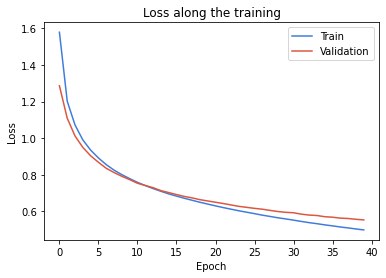

Custo treino 0.4983150229464863
Custo validação 0.5530654008781298


In [30]:
#Testando modelo com 4 camadas, sendo 2 camadas escondidas
model = Model([2352,900, 400, 8], [ReLU(), ReLU(),Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(40, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

> What are the conclusions? How does the number of layers impact the performance of the models? (2-4 paragraphs) 

Testamos primeiramente 2 possibilidades de modelos com 5 camadas e depois 2 possibilidades de modelos com 6 camadas, como nenhum delas foi melhor ou próxima a do modelo com 4 camadas construído previamente escolhemos definir o número de camadas como 4 com duas camadas escondidas e então testar possibilidades dos números de neurônios nessas camadas escondidas


5. (2 points) Pick the best network architecture and train your model using the optimizer you chose to implement.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/250 [00:00<?, ?it/s]

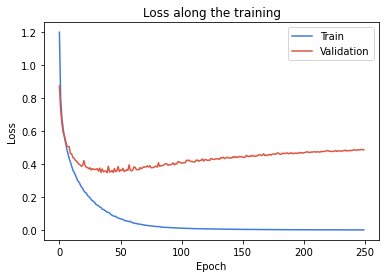

Custo treino 0.0022101519822365478
Custo validação 0.48682116644037404


In [101]:
model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = MomentumSGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(250, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

> What are the conclusions? Does the change of optimizer anyhow impact the loss curve over the epochs? (1-2 paragraphs) 

Pode-se perceber que o optimizador Momentum converge mais rápido do que o SGD, uma vez que esta mesma rede foi treinada utilizando SGD previamente e obteve-se um custo de aproximadamente 0,37 com 250 épocas
enquanto utilizando Momentum obeteve aproximadamente 0,48 com 250 épocas, contudo analisando o gráfico é possível perceber que o custo de validação estabiliza rapidamente e depois ele começa a subir, sendo assim, possívelmente seria interessante treinar um modelo utilizando o optimizador momentum porém com menos épocas.

6. (1 point) Pick your **best model**, make predictions to the test set and submit them to the Kaggle competition [3rd ML Assignment](https://www.kaggle.com/t/cbf42d49ae514153bd4d04e0a69d684f). Print your score considering the public leaderboard.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/250 [00:00<?, ?it/s]

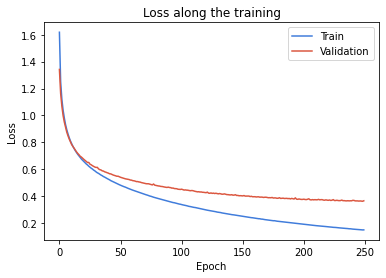

Custo treino 0.14951459389221752
Custo validação 0.3656651432670185


In [39]:
prelu = PReLU()
prelu.alpha = 0.5
model = Model([2352, 500, 100, 8], [prelu, prelu, Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(250, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/45 [00:00<?, ?it/s]

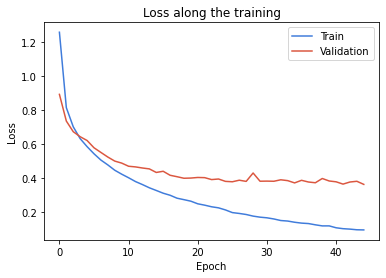

Custo treino 0.09236522723445476
Custo validação 0.3610790797189672


In [103]:
#testando a rede com momentum
prelu = PReLU()
prelu.alpha = 0.5
model = Model([2352, 500, 100, 8], [prelu, prelu, Softmax()], initialization_method="he")
opt = MomentumSGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(45, train_loader, val_loader)
plot_history(history)
print('Custo treino',history['train_loss'][len(history['train_loss'])-1])
print('Custo validação',history['val_loss'][len(history['val_loss'])-1])

In [104]:
Y_pred = []
for i, batch in enumerate(test_loader):                
                X = batch
                X = X.numpy()                        
                Y_pred.append(model.forward(X))


In [106]:
predicoes = []
for c in range(0,len(Y_pred)):
  for k in range(0,len(Y_pred[c])):
    obs = Y_pred[c][k]
    predicoes.append(np.argmax(obs))

In [107]:
index = np.arange(start = 0, stop = len(predicoes), step = 1)
submission = pd.DataFrame({'index':index,
                           'cell_type': predicoes})
submission

,index,cell_type
0,0,5
1,1,0
2,2,1
3,3,3
4,4,1
...,...,...
3416,3416,6
3417,3417,3
3418,3418,3
3419,3419,1


In [108]:
submission.to_csv('submission.csv', index = False)

> What are the conclusions? (1-2 paragraphs)

Podemos perceber que não há diferença significativa entre as funções de ativação PreLU e ReLU, quanto a inicialização dos pesos o método de he Normalization parece ser mais eficiente, e por fim o optimizador Momentum acelera a descida de gradiente e permite chegarmos numa solução boa com custo computacional normal.

Tendo em vista todos este pontos citados, e também os testes empíricos realizados na questão 4 em que percebemos que aparentemente a estrutura mais adequada seria de 3 camadas, montamos nosso modelo final que obteve um score de 0,88523 na competição do kaggle.